# House Prices


In [71]:
hold_out_size=0.2

# Loading packeges and data

In [72]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()


from catboost import CatBoostRegressor, Pool, cv

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold, RepeatedKFold
from sklearn.metrics import mean_squared_error as mse

import eli5
from eli5.sklearn import PermutationImportance

import hyperopt

from numpy.random import RandomState
from os import listdir


import shap
# load JS visualization code to notebook
shap.initjs()

In [73]:
listdir("../input")

['house-prices-advanced-regression-techniques']

## Helper methods

In [ ]:
def run_catboost(traindf, testdf, holddf, params, n_splits=10, n_repeats=1,
                 plot=False, use_features=None, plot_importance=True):
    
    
    folds = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=1)
    p_hold = np.zeros(holddf.shape[0])
    y_hold = holddf.target
    p_test = np.zeros(testdf.shape[0])
    
    if use_features is None:
        use_features = testdf.columns.values
    
    cat_features = np.where(testdf.loc[:, use_features].dtypes=="object")[0]
    x_hold = holddf.loc[:, use_features]
    x_test = testdf.loc[:, use_features]
    
    feature_importance_df = pd.DataFrame(index=use_features)
    
    m = 0
    cv_scores = []
    for train_idx, dev_idx in folds.split(traindf):
        x_train, x_dev = traindf.iloc[train_idx][use_features], traindf.iloc[dev_idx][use_features]
        y_train, y_dev = traindf.target.iloc[train_idx], traindf.target.iloc[dev_idx]

        train_pool = Pool(x_train, y_train, cat_features=cat_features)
        dev_pool = Pool(x_dev, y_dev, cat_features=cat_features)
        model = CatBoostRegressor(**params)
        model.fit(train_pool, eval_set=dev_pool, plot=plot)

        # bagging predictions for test and hold out data:
        p_hold += model.predict(x_hold)/(n_splits*n_repeats)
        log_p_test = model.predict(x_test)
        p_test += (np.exp(log_p_test) - 1)/(n_splits*n_repeats)

        # predict for dev fold:
        y_pred = model.predict(x_dev)
        feature_importance_df.loc[:, "fold_" + str(m)] = model.get_feature_importance(train_pool)
        cv_scores.append(np.sqrt(mse(y_dev, y_pred)))
        m+=1

    print("hold out rmse: " + str(np.sqrt(mse(y_hold, p_hold))))
    print("cv mean rmse: " + str(np.mean(cv_scores)))
    print("cv std rmse: " + str(np.std(cv_scores)))
    
    feature_importance_df["mean"] = feature_importance_df.mean(axis=1)
    feature_importance_df["std"] = feature_importance_df.std(axis=1)
    feature_importance_df = feature_importance_df.sort_values(by="mean", ascending=False)
    
    if plot_importance:
        plt.figure(figsize=(15,20))
        sns.barplot(x=feature_importance_df["mean"].values[0:50], y=feature_importance_df.index.values[0:50]);
        plt.title("Feature importances");
        plt.show()
    
    results = {"last_model": model,
               "last_train_pool": train_pool,
               "feature_importance": feature_importance_df, 
               "p_hold": p_hold,
               "p_test": p_test,
               "cv_scores": cv_scores}
    return results

#Data exploration 

### data training 

In [121]:
train = pd.read_csv("../input/house-prices-advanced-regression-techniques/train.csv", index_col=0)
train.head()

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
Id                                                                    
1           60       RL         65.0     8450   Pave   NaN      Reg   
2           20       RL         80.0     9600   Pave   NaN      Reg   
3           60       RL         68.0    11250   Pave   NaN      IR1   
4           70       RL         60.0     9550   Pave   NaN      IR1   
5           60       RL         84.0    14260   Pave   NaN      IR1   

   LandContour Utilities LotConfig  ... PoolArea PoolQC Fence MiscFeature  \
Id                                  ...                                     
1          Lvl    AllPub    Inside  ...        0    NaN   NaN         NaN   
2          Lvl    AllPub       FR2  ...        0    NaN   NaN         NaN   
3          Lvl    AllPub    Inside  ...        0    NaN   NaN         NaN   
4          Lvl    AllPub    Corner  ...        0    NaN   NaN         NaN   
5          Lvl    AllPub       FR2  ...        0    NaN   NaN         NaN   

   MiscVal MoSold  YrSold  SaleType  SaleCondition  SalePrice  
Id                                                             
1        0      2    2008        WD         Normal     208500  
2        0      5    2007        WD         Normal     181500  
3        0      9    2008        WD         Normal     223500  
4        0      2    2006        WD        Abnorml     140000  
5        0     12    2008        WD         Normal     250000  

[5 rows x 80 columns]

In [122]:
train.shape

(1460, 80)

### data test 

In [123]:
test = pd.read_csv("../input/house-prices-advanced-regression-techniques/test.csv", index_col=0)
test.head()

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
Id                                                                      
1461          20       RH         80.0    11622   Pave   NaN      Reg   
1462          20       RL         81.0    14267   Pave   NaN      IR1   
1463          60       RL         74.0    13830   Pave   NaN      IR1   
1464          60       RL         78.0     9978   Pave   NaN      IR1   
1465         120       RL         43.0     5005   Pave   NaN      IR1   

     LandContour Utilities LotConfig  ... ScreenPorch PoolArea PoolQC  Fence  \
Id                                    ...                                      
1461         Lvl    AllPub    Inside  ...         120        0    NaN  MnPrv   
1462         Lvl    AllPub    Corner  ...           0        0    NaN    NaN   
1463         Lvl    AllPub    Inside  ...           0        0    NaN  MnPrv   
1464         Lvl    AllPub    Inside  ...           0        0    NaN    NaN   
1465         HLS    AllPub    Inside  ...         144        0    NaN    NaN   

     MiscFeature MiscVal  MoSold  YrSold  SaleType  SaleCondition  
Id                                                                 
1461         NaN       0       6    2010        WD         Normal  
1462        Gar2   12500       6    2010        WD         Normal  
1463         NaN       0       3    2010        WD         Normal  
1464         NaN       0       6    2010        WD         Normal  
1465         NaN       0       1    2010        WD         Normal  

[5 rows x 79 columns]

In [124]:
test.shape

(1459, 79)

In [79]:
train.shape[0] / test.shape[0]

1.0006854009595614

The training data has almost the same size as the test data!

### Submission

In [125]:
submission = pd.read_csv("../input/house-prices-advanced-regression-techniques/sample_submission.csv", index_col=0)
submission.head()

SalePrice
Id                 
1461  122025.439989
1462  150272.010290
1463  203630.052336
1464  208729.676317
1465  212326.053163

# Data exploration and cleaning 
#

## Target distribution

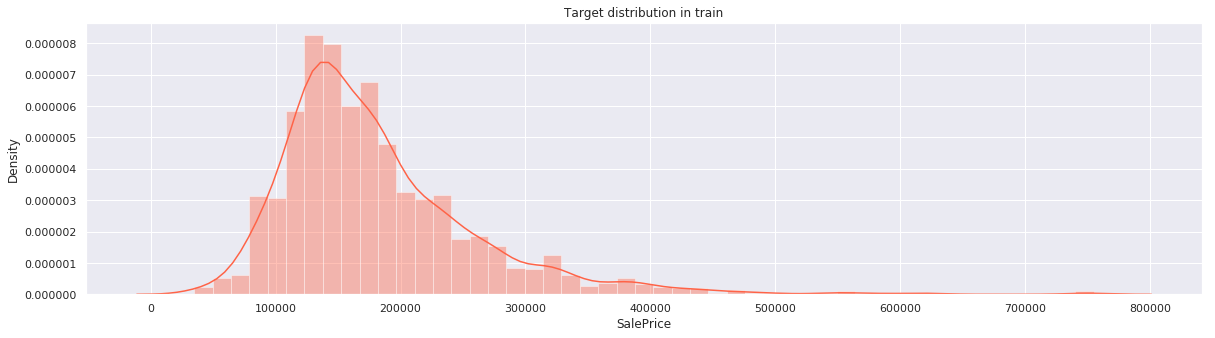

In [81]:
plt.figure(figsize=(20,5))
sns.distplot(train.SalePrice, color="tomato")
plt.title("Target distribution in train")
plt.ylabel("Density");

The sale price distribution is right-skewed and shows extreme outliers. In the case we are going to use the mean squared error loss for optimization, we should log transform the predictions and the target values!

In [82]:
train[train.SalePrice <=0 ]

Empty DataFrame
Columns: [MSSubClass, MSZoning, LotFrontage, LotArea, Street, Alley, LotShape, LandContour, Utilities, LotConfig, LandSlope, Neighborhood, Condition1, Condition2, BldgType, HouseStyle, OverallQual, OverallCond, YearBuilt, YearRemodAdd, RoofStyle, RoofMatl, Exterior1st, Exterior2nd, MasVnrType, MasVnrArea, ExterQual, ExterCond, Foundation, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinSF1, BsmtFinType2, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, Heating, HeatingQC, CentralAir, Electrical, 1stFlrSF, 2ndFlrSF, LowQualFinSF, GrLivArea, BsmtFullBath, BsmtHalfBath, FullBath, HalfBath, BedroomAbvGr, KitchenAbvGr, KitchenQual, TotRmsAbvGrd, Functional, Fireplaces, FireplaceQu, GarageType, GarageYrBlt, GarageFinish, GarageCars, GarageArea, GarageQual, GarageCond, PavedDrive, WoodDeckSF, OpenPorchSF, EnclosedPorch, 3SsnPorch, ScreenPorch, PoolArea, PoolQC, Fence, MiscFeature, MiscVal, MoSold, YrSold, SaleType, SaleCondition, SalePrice]
Index: []

[0 rows x 80 columns]

We don't have to worry about negative or zero house prices.

## Missing values

In [83]:
combined = train.drop("SalePrice", axis=1).append(test)
nan_percentage = combined.isnull().sum().sort_values(ascending=False) / combined.shape[0]
missing_val = nan_percentage[nan_percentage > 0]

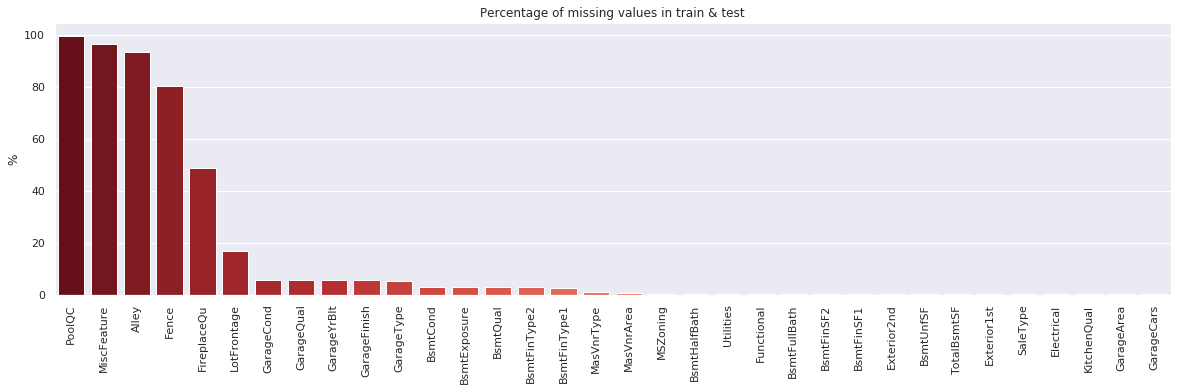

In [84]:
plt.figure(figsize=(20,5))
sns.barplot(x=missing_val.index.values, y=missing_val.values * 100, palette="Reds_r");
plt.title("Percentage of missing values in train & test");
plt.ylabel("%");
plt.xticks(rotation=90);

Ok, first decision to make: Let's drop all features with missing values above 10 %.

In [85]:
to_drop = missing_val[missing_val > 0.1].index.values
combined = combined.drop(to_drop, axis=1)
combined.shape

(2919, 73)

In [86]:
to_drop

array(['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu',
       'LotFrontage'], dtype=object)

## Categorical candidates

In [87]:
cat_candidates = combined.dtypes[combined.dtypes=="object"].index.values
cat_candidates

array(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual',
       'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', 'KitchenQual', 'Functional',
       'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
       'PavedDrive', 'SaleType', 'SaleCondition'], dtype=object)

### Feature Importance by level frequencies
# 
# Some categorical features might be completely useless as only some levels occur most of the time (no diversity). To get more insights, we can compute the frequency of the most common level in the train & test data:

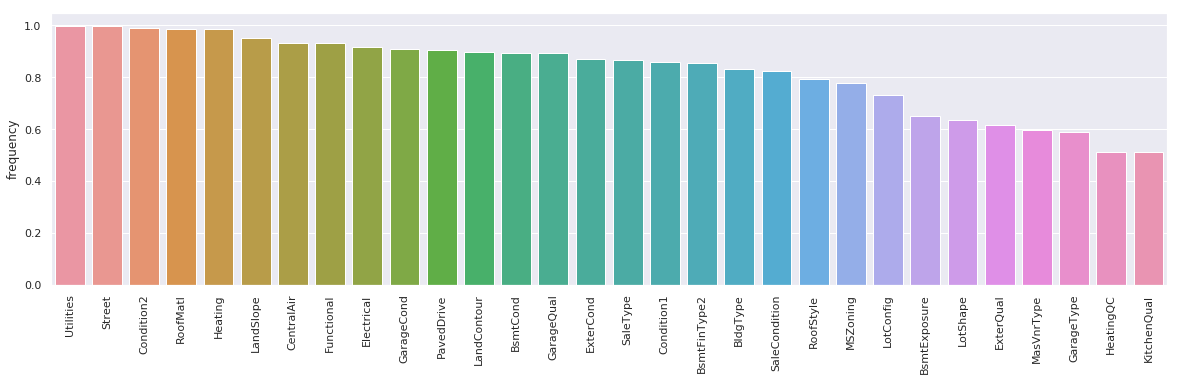

In [88]:
frequencies = []
for col in cat_candidates:
    overall_freq = combined.loc[:, col].value_counts().max() / combined.shape[0]
    frequencies.append([col, overall_freq])

frequencies = np.array(frequencies)
freq_df = pd.DataFrame(index=frequencies[:,0], data=frequencies[:,1], columns=["frequency"])
sorted_freq = freq_df.frequency.sort_values(ascending=False)

plt.figure(figsize=(20,5))
sns.barplot(x=sorted_freq.index[0:30], y=sorted_freq[0:30].astype(np.float))
plt.xticks(rotation=90);

### Insights
# 
# Many categorical candidates have one major level that occupies > 80 % of the data. That's bad. What should we learn from such a feature? Let's pick some examples:

In [89]:
example = "Utilities"
combined.loc[:,example].value_counts()

AllPub    2916
NoSeWa       1
Name: Utilities, dtype: int64

This is a completely useless feature! Let's drop all features that show a most common value of 90 %.

In [90]:
freq_df.frequency = freq_df.frequency.astype(np.float)
cats_to_drop = freq_df[freq_df.frequency >= 0.9].index.values
len(cats_to_drop)

11

In [91]:
cats_to_drop

array(['Street', 'Utilities', 'LandSlope', 'Condition2', 'RoofMatl',
       'Heating', 'CentralAir', 'Electrical', 'Functional', 'GarageCond',
       'PavedDrive'], dtype=object)

In [92]:
combined = combined.drop(cats_to_drop, axis=1)
combined.shape

(2919, 62)

In [93]:
cat_candidates = combined.dtypes[combined.dtypes=="object"].index.values
cat_candidates

array(['MSZoning', 'LotShape', 'LandContour', 'LotConfig', 'Neighborhood',
       'Condition1', 'BldgType', 'HouseStyle', 'RoofStyle', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'KitchenQual',
       'GarageType', 'GarageFinish', 'GarageQual', 'SaleType',
       'SaleCondition'], dtype=object)

### Fusing categorical levels
# 
# Let's dive deeper into explorations by discovering each remaining categorical candidate:

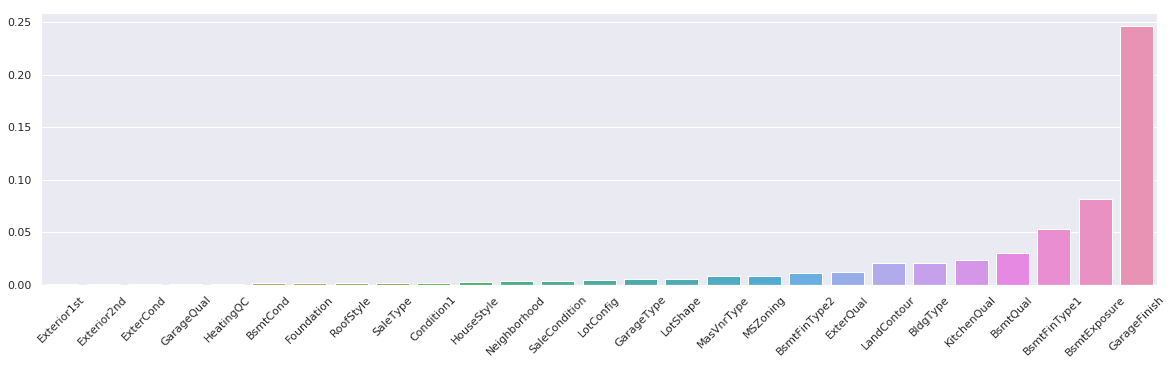

In [94]:
min_frequency = pd.Series(index=cat_candidates)
for col in cat_candidates:
    min_frequency.loc[col] = combined.loc[:,col].value_counts().min() / combined.shape[0]
min_frequency = min_frequency.sort_values()

plt.figure(figsize=(20,5))
sns.barplot(x=min_frequency.index, y=min_frequency.values)
plt.xticks(rotation=45);

### Insights
# 
# * Many categorical candidates have less frequent levels. 
# * This is a problem as it might be difficult to generalize well during training if there is only a handful of samples with a specific level. 
# * We could either fuse levels or we add information to the frequency of levels as well as level target information like mean, median, std. 
# * As I would like to do more stuff automatically, let's choose the second way after dealing with the numerical features.

## Numerical candidates

In [95]:
num_candidates = combined.dtypes[combined.dtypes!="object"].index.values
num_candidates

array(['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold'],
      dtype=object)

In [96]:
combined.loc[:, num_candidates].head(10)

MSSubClass  LotArea  OverallQual  OverallCond  YearBuilt  YearRemodAdd  \
Id                                                                           
1           60     8450            7            5       2003          2003   
2           20     9600            6            8       1976          1976   
3           60    11250            7            5       2001          2002   
4           70     9550            7            5       1915          1970   
5           60    14260            8            5       2000          2000   
6           50    14115            5            5       1993          1995   
7           20    10084            8            5       2004          2005   
8           60    10382            7            6       1973          1973   
9           50     6120            7            5       1931          1950   
10         190     7420            5            6       1939          1950   

    MasVnrArea  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  ...  GarageArea  \
Id                                                 ...               
1        196.0       706.0         0.0      150.0  ...       548.0   
2          0.0       978.0         0.0      284.0  ...       460.0   
3        162.0       486.0         0.0      434.0  ...       608.0   
4          0.0       216.0         0.0      540.0  ...       642.0   
5        350.0       655.0         0.0      490.0  ...       836.0   
6          0.0       732.0         0.0       64.0  ...       480.0   
7        186.0      1369.0         0.0      317.0  ...       636.0   
8        240.0       859.0        32.0      216.0  ...       484.0   
9          0.0         0.0         0.0      952.0  ...       468.0   
10         0.0       851.0         0.0      140.0  ...       205.0   

    WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea  \
Id                                                                             
1            0           61              0          0            0         0   
2          298            0              0          0            0         0   
3            0           42              0          0            0         0   
4            0           35            272          0            0         0   
5          192           84              0          0            0         0   
6           40           30              0        320            0         0   
7          255           57              0          0            0         0   
8          235          204            228          0            0         0   
9           90            0            205          0            0         0   
10           0            4              0          0            0         0   

    MiscVal  MoSold  YrSold  
Id                           
1         0       2    2008  
2         0       5    2007  
3         0       9    2008  
4         0       2    2006  
5         0      12    2008  
6       700      10    2009  
7         0       8    2007  
8       350      11    2009  
9         0       4    2008  
10        0       1    2008  

[10 rows x 35 columns]

* Just by looking at the data we can see that there are a lot of features that are not numeric but categorical like OverallQual and OverallCond.

In [97]:
next_cat_candidates = [
    "OverallQual", "OverallCond", "MSSubClass", 'BsmtFullBath',
    'BsmtHalfBath','FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
    'TotRmsAbvGrd', 'Fireplaces', 'GarageCars'
]
len(next_cat_candidates)

12

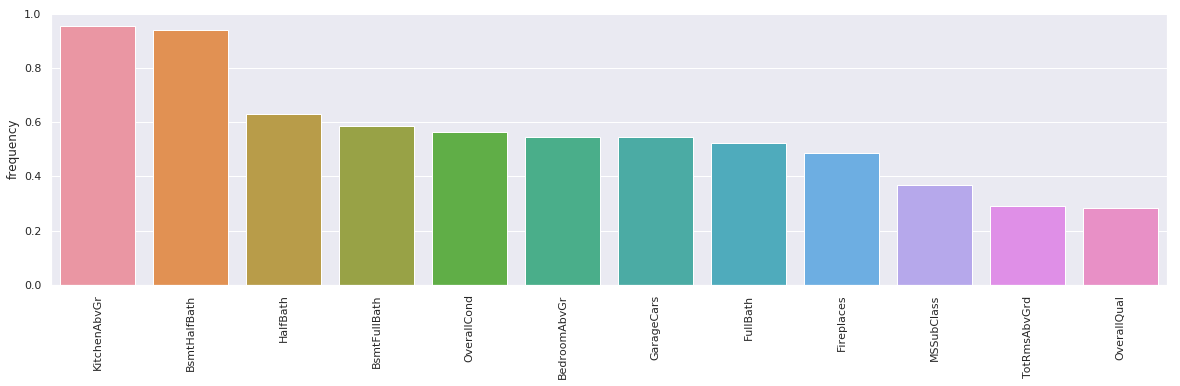

In [98]:
frequencies = []
for col in next_cat_candidates:
    overall_freq = combined.loc[:, col].value_counts().max() / combined.shape[0]
    frequencies.append([col, overall_freq])

frequencies = np.array(frequencies)
freq_df = pd.DataFrame(index=frequencies[:,0], data=frequencies[:,1], columns=["frequency"])
sorted_freq = freq_df.frequency.sort_values(ascending=False)

plt.figure(figsize=(20,5))
sns.barplot(x=sorted_freq.index[0:30], y=sorted_freq[0:30].astype(np.float))
plt.xticks(rotation=90);

In [99]:
cats_to_drop = ["KitchenAbvGr", "BsmtHalfBath"]
combined = combined.drop(cats_to_drop, axis=1)

In [100]:
for col in cats_to_drop:
    next_cat_candidates.remove(col)

In [101]:
for col in next_cat_candidates:
    combined[col] = combined[col].astype("object")

In [102]:
num_candidates = combined.dtypes[combined.dtypes!="object"].index.values
num_candidates

array(['LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'GarageYrBlt', 'GarageArea',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold'],
      dtype=object)

## Imputing missing values

In [103]:
def impute_na_trees(df, col):
    if df[col].dtype == "object":
        df[col] = df[col].fillna("Unknown")
        df[col] = df[col].astype("object")
    else:
        df[col] = df[col].fillna(-99999)
    return df

def impute_na_no_trees(df, col):
    if df[col].dtype == "object":
        df[col] = df[col].fillna("Unknown")
    else:
        df[col] = df[col].fillna("median")
    return df

In [104]:
num_candidates = combined.dtypes[combined.dtypes!="object"].index.values
num_candidates

array(['LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'GarageYrBlt', 'GarageArea',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold'],
      dtype=object)

In [105]:
for col in combined.columns:
    combined = impute_na_trees(combined, col)

In [106]:
combined.isnull().sum().sum()

0

# Computing benchmark predictions with catboost
# 
# This data has many categorical features and one model that can deal nicely with these kind of features is [catboost](https://catboost.ai/). If you like to read more about it, you can find a [paper here](https://arxiv.org/abs/1706.09516). Actually we have dropped all categorical features by encoding them but later on after feature exploration we may like to use them with catboost to use target encoding as well.

In [107]:
traindf = combined.iloc[0:train.shape[0]].copy()
traindf.loc[:, "target"] = np.log(train.SalePrice+1)
testdf = combined.iloc[train.shape[0]::].copy()

### Generating hold out data
# 
# I like to use the hold out data later for ensembling.

In [108]:
traindf, holddf = train_test_split(traindf, test_size=0.2, random_state=0)
print((traindf.shape, holddf.shape, testdf.shape))

((1168, 61), (292, 61), (1459, 60))


### Model parameter

In [109]:
org_params = {
    'iterations': 1000,
    'learning_rate': 0.1,
    'eval_metric': 'RMSE',
    'random_seed': 42,
    'logging_level': 'Silent',
    'use_best_model': True,
    'loss_function': 'RMSE',
    'od_type': 'Iter',
    'od_wait': 200,
    'one_hot_max_size': 5,
    'l2_leaf_reg': 3,
    'depth': 4
}

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

hold out rmse: 0.15922656355153417
cv mean rmse: 0.167988211316072
cv std rmse: 0.0172421100350493


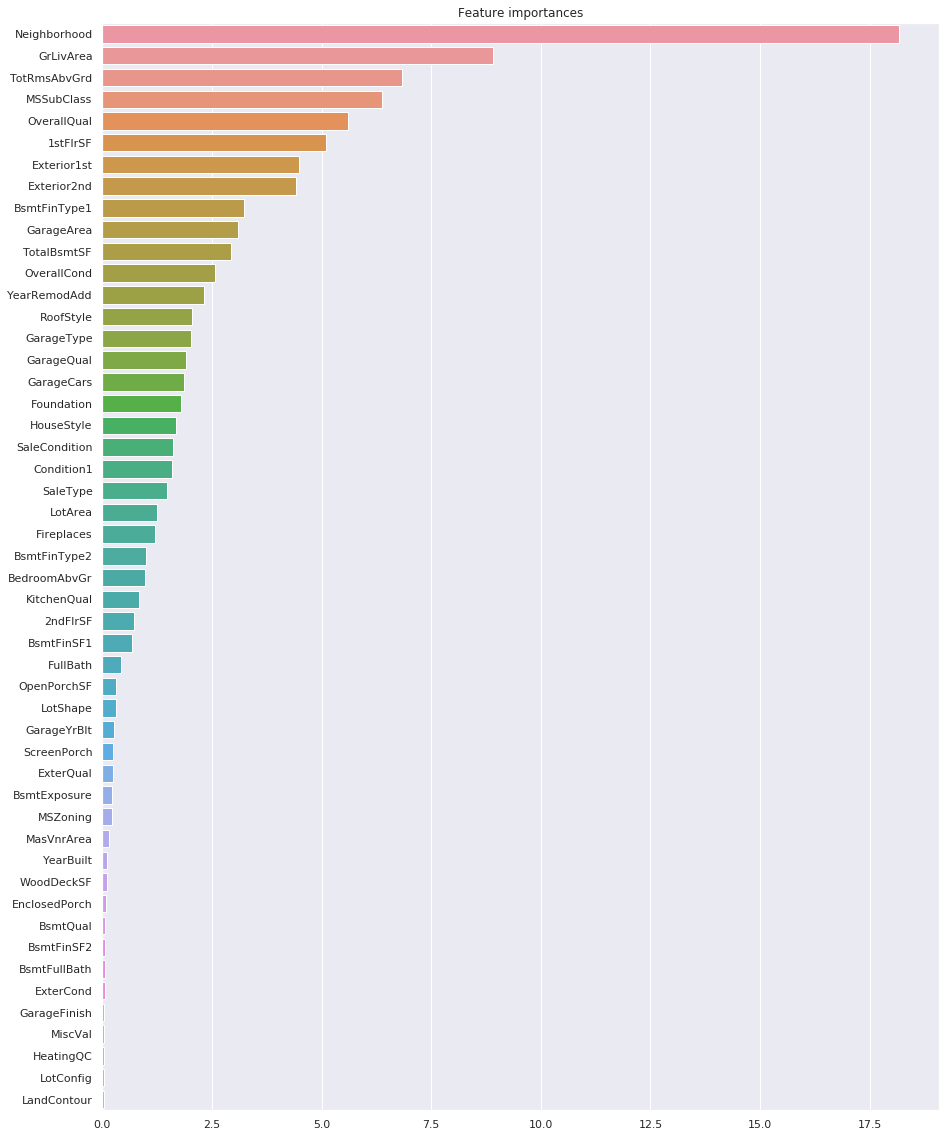

In [110]:
results = run_catboost(traindf, 
                       testdf,
                       holddf,
                       org_params,
                       plot=True,
                       n_splits=6,
                       n_repeats=1)
p_hold = results["p_hold"]
p_test = results["p_test"]
feature_importance_df = results["feature_importance"]

### Insights
# 
# * A lot of feature were not used by catboost and seem to be not important. 
# * You can see that many of them belong to those features that show only a few variation like LandContour, BsmtCond and GarageQual. 
# * This confirms our approach to drop such kind of features even more.

In [111]:
feature_importance_df.head(5)

fold_0     fold_1     fold_2     fold_3     fold_4  \
Neighborhood  17.697957  18.824516  19.099684  16.994658  16.150575   
GrLivArea      8.893026  10.636884   6.841334  10.099038   9.782938   
TotRmsAbvGrd   6.466232   7.049294   5.940627   6.773290   6.239896   
MSSubClass     5.772528   6.784041   6.370200   7.305498   5.493500   
OverallQual    4.395130   7.617371   6.090615   4.548238   5.940451   

                 fold_5       mean       std  
Neighborhood  20.270315  18.172951  1.377577  
GrLivArea      7.211397   8.910770  1.433113  
TotRmsAbvGrd   8.487293   6.826105  0.823546  
MSSubClass     6.577084   6.383809  0.607392  
OverallQual    5.078911   5.611786  1.099622

### Insights
# 
# * There is a lot of variation of the feature importance between folds! What does this mean?
#     * How useful a feature is to fit the training data depends on the data itself and how big the dataset is.
#     * If you increase the number of splits the most important features will change! Try it out!
#     * Remember that our test dataset is the same size as the training dataset. It's very likely that we will overfit to our training data and that we will not be able to generalize well on the test data. 
# * What can we do to reduce this problem?
#     * We should drop features that almost have no importance!
#     * We should include more randomess to our KFold as well (run it several times, make averaged predictions with each KFold)
#     * We should use different models that contribute to our prediction.
# 
# Let's figure it out by playing with these concepts. ;-)
#

In [112]:
submission.loc[testdf.index.values, "SalePrice"] = p_test
submission = submission.reset_index()
submission.head()

Id      SalePrice
0  1461  122025.439989
1  1462  150272.010290
2  1463  203630.052336
3  1464  208729.676317
4  1465  212326.053163

In [113]:
submission.to_csv("submission_before_feature_selection.csv", index=False)
submission = submission.set_index("Id")
submission.head()

SalePrice
Id                 
1461  122025.439989
1462  150272.010290
1463  203630.052336
1464  208729.676317
1465  212326.053163

In [114]:
sorted_features = feature_importance_df.sort_values(by="mean").index.values
len(sorted_features)

60

# Cleaning up the features!
# 
# As we need to encode our categorical features to work with sklearn, we need to define more precisely the type:
# 
# * **Ordinal features** have a sense of order like many values we observed that holds quality data like "ExterQual" or "BsmtQual".
# * **Nomial features** do not have this kind of order. A good example would be the Neighborhood feature of this data.
# 
# Before we can really start with feature selection, we need to clean up our dataset! :-)
#

## Extracting categorical features in numerical candidates

Let's take again a look at our numerical candidates:

In [115]:
num_candidates = combined.dtypes[combined.dtypes!="object"].index.values
num_candidates

array(['LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'GarageYrBlt', 'GarageArea',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold'],
      dtype=object)

Numerical features should have many various different values. This is not the case for all of our candidates:

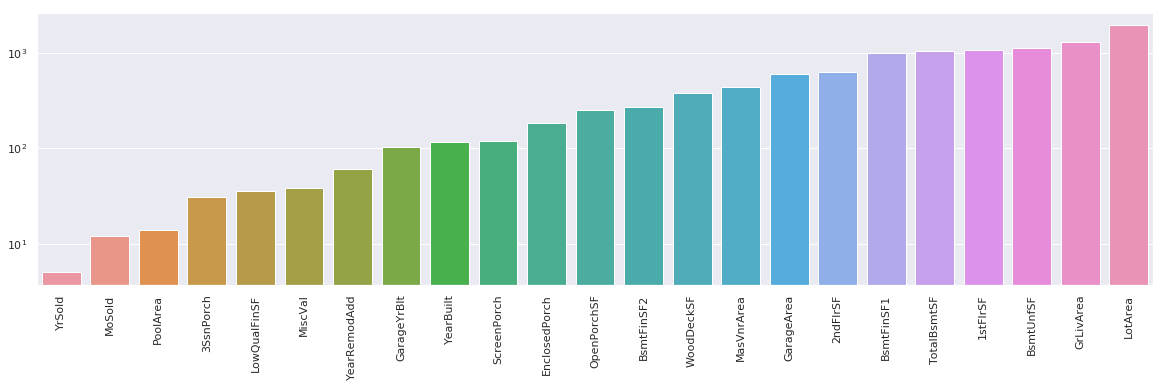

In [116]:
unique_counts = combined.loc[:, num_candidates].nunique().sort_values()

plt.figure(figsize=(20,5))
sns.barplot(unique_counts.index, unique_counts.values)
plt.xticks(rotation=90);
plt.yscale("log")

* Every feature with SF or area can be considered as numerical. 
# * But YrSold and MoSold do not have many different values and may be better considered as categorical.

In [117]:
num_to_cat_cols = ["YrSold", "MoSold"]

cat_candidates = list(cat_candidates)
num_candidates = list(num_candidates)
for col in num_to_cat_cols:
    cat_candidates.extend(col)
    num_candidates.remove(col)

num_candidates = np.array(num_candidates)
cat_candidates = np.array(cat_candidates)

## Encoding categorical features

In [118]:
cat_candidates

array(['MSZoning', 'LotShape', 'LandContour', 'LotConfig', 'Neighborhood',
       'Condition1', 'BldgType', 'HouseStyle', 'RoofStyle', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'KitchenQual',
       'GarageType', 'GarageFinish', 'GarageQual', 'SaleType',
       'SaleCondition', 'Y', 'r', 'S', 'o', 'l', 'd', 'M', 'o', 'S', 'o',
       'l', 'd'], dtype='<U13')

In [119]:
len(cat_candidates)

39

### Ordinal or not?
# 
# To answer this question we should take a look at the target distribution for each level per categorical candidate. This way we can easily see if there is some kind of order we can pick up! ;-)

ValueError: Could not interpret input 'Y'

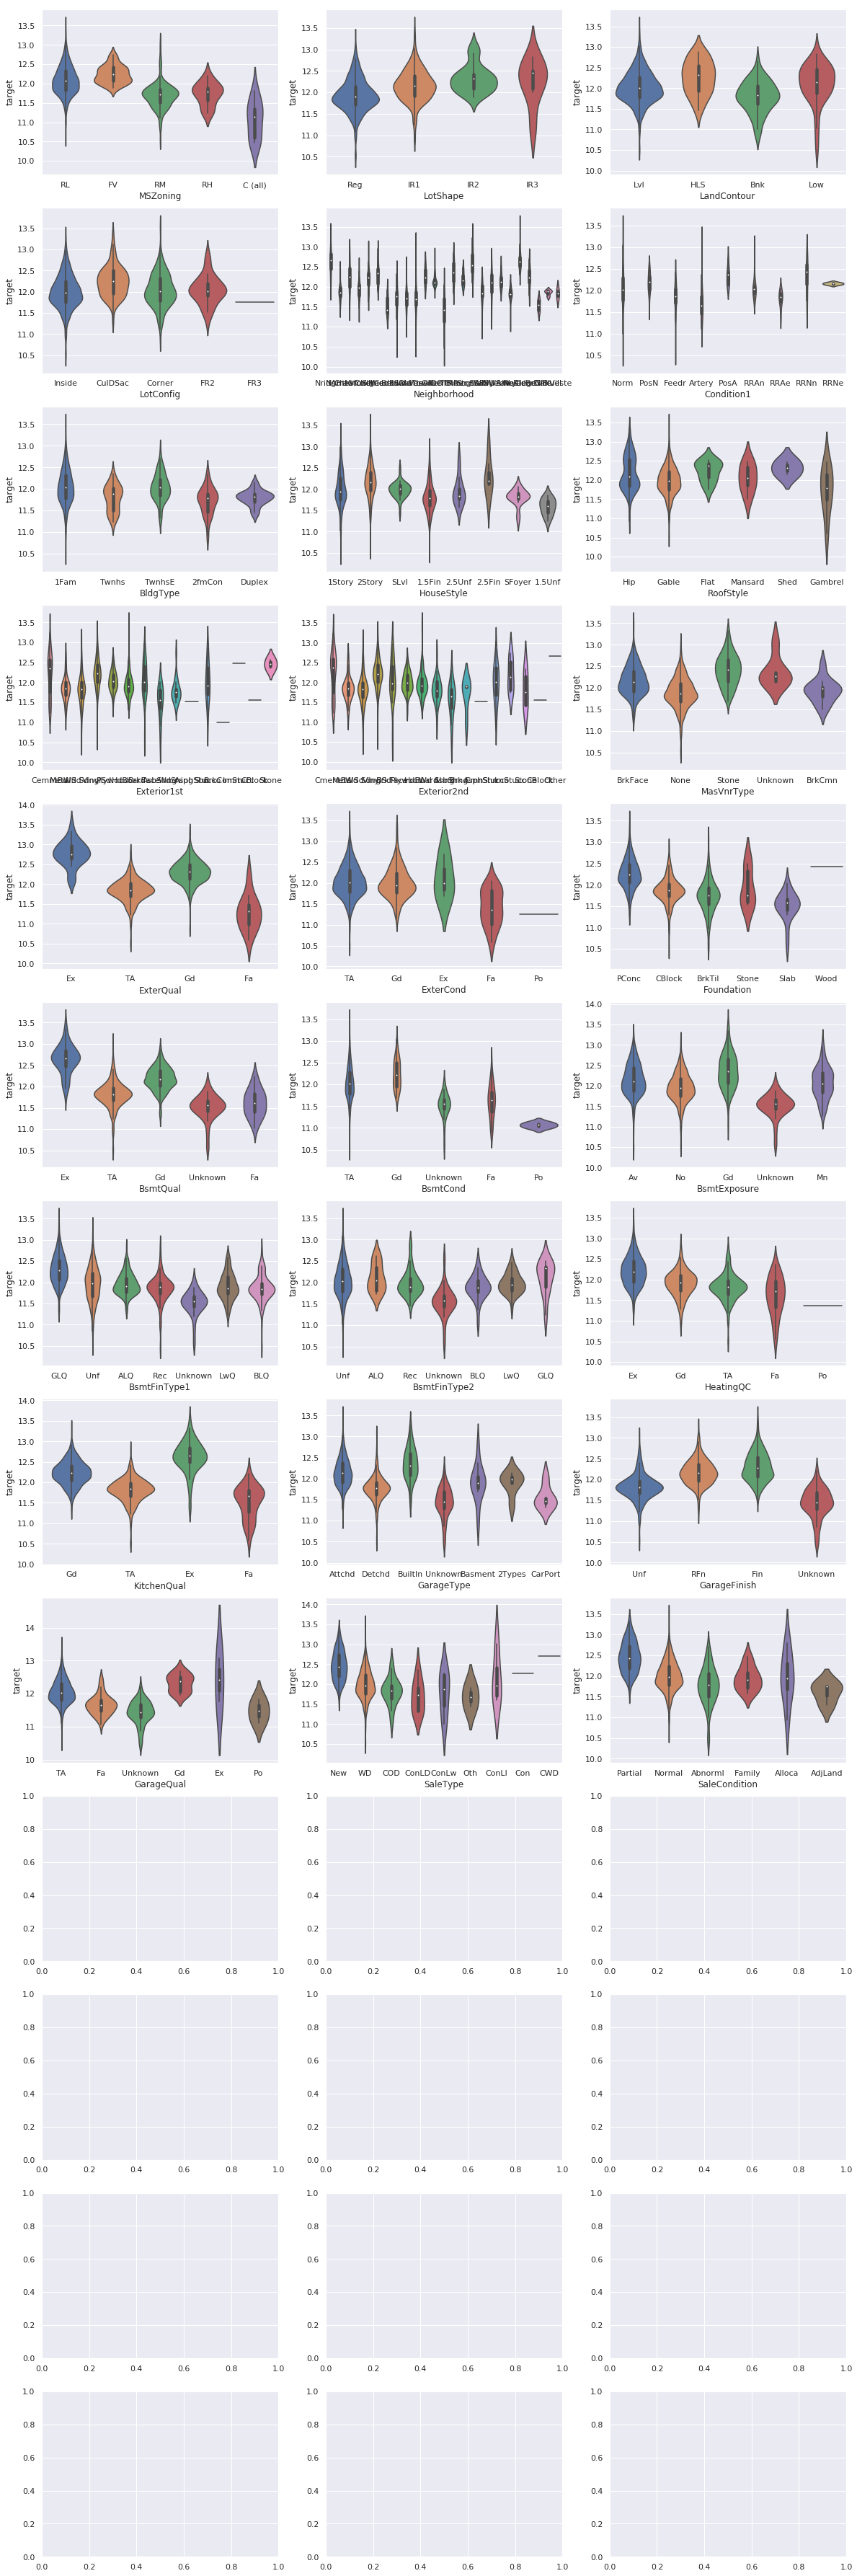

In [120]:
fig, ax = plt.subplots(13,3,figsize=(20,5*13))

for n in range(13):
    for m in range(3):
        col = cat_candidates[m+n*3]
        sns.violinplot(x=col, y="target", data=traindf, ax=ax[n,m])

### Insights
# 
# * Features like HalfBath, Fireplaces, HeatingQC, OverallQual, TotRmsAbvGrd, OverallCond, FullBath directly show order with respect to the target.
# * In contrast there are some features that could be ordinal but levels might need to be fused or ordering need to be done manually like for: KitchenQual, GarageFinish, GarageCars, BsmtExposure, BsmtQual, BsmtCondExterQual.
# * We can also find pure nominal features like SaleType, Neighborhood, MasVnrType, MSZoning or MSSubClass (and many more) that show no intuitive order at all.

### Brute force encoding 
# 
# All features that we consider as ordinal should be encoded with integers that reflect what we have found. As we have found features for which the order might not be easily extracted, I like to go with a brute force approach.

In [ ]:
ordinal_candidates = ["HalfBath", "ExterCond", "BedroomAbvGr", "HeatingQC", "Fireplaces", "GarageFinish", "KitchenQual",
                      "GarageCars", "BsmtFullBath", "GarageQual", "FullBath", "OverallCond", "TotRmsAbvGrd",
                      "BsmtExposure", "BsmtQual", "BsmtCond", "LotShape", "OverallQual", "ExterQual"]

In [ ]:
enc_map = {}

for col in ordinal_candidates:
    order = traindf.groupby(col).target.median().sort_values().index.values
    enc_map[col] = {}
    for n in range(len(order)):
        enc_map[col][order[n]] = n

In [ ]:
new_combined = combined.copy()

In [ ]:
for col in ordinal_candidates:
    new_combined[col] = combined[col].map(enc_map[col])

In [ ]:
new_combined.loc[:, ordinal_candidates].isnull().sum()

In [ ]:
new_combined.loc[:, ordinal_candidates] = new_combined.loc[:, ordinal_candidates].fillna(-1)

In [ ]:
new_combined.isnull().sum().sum()

# Feature selection
# 
# We could try to remove features recursively. I like this approach very much but it costs a lot of time to evaluate the model every time. For this purpose we should try to use simpler models like a linear model and a random forest.
# 
# ## Random forest

In [ ]:
from sklearn.feature_selection import RFECV

forest = RandomForestRegressor(max_depth=8)

kfold = KFold(6)
rfecv = RFECV(estimator=forest, step=1, scoring="rmse", n_jobs=-1)

In [ ]:
X = combined.values

X_train = traindf.drop("target", axis=1).values
Y_train = traindf.target.values

X_test = testdf.values
X_hold = holddf.values

In [ ]:
from sklearn.preprocessing import OrdinalEncoder

encoder = OrdinalEncoder()
#X = encoder.fit_transform(X)
#X_train = encoder.transform(X_train)
#X_test = encoder.transform(X_test)
#X_hold = encoder.transform(X_hold)

### Linear model

# Feature engineering

## Feature Interaction
# 
# With catboost we can also discover feature interactions with a depth > 1. This way we can see which features are often found as a combination in single trees:

In [ ]:
cat_features = np.where(testdf.dtypes == "object")[0]

In [ ]:
x_train, x_dev = traindf.drop("target", axis=1), holddf.drop("target", axis=1)
y_train, y_dev = traindf.target, holddf.target

train_pool = Pool(x_train, y_train, cat_features=cat_features)
dev_pool = Pool(x_dev, y_dev, cat_features=cat_features)
model = CatBoostRegressor(**org_params)
model.fit(train_pool, eval_set=dev_pool, plot=True)

I really love the next feature: ;-)

In [ ]:
interaction = model.get_feature_importance(train_pool, type="Interaction")
column_names = testdf.columns.values 
interaction = pd.DataFrame(interaction, columns=["feature1", "feature2", "importance"])
interaction.feature1 = interaction.feature1.apply(lambda l: column_names[int(l)])
interaction.feature2 = interaction.feature2.apply(lambda l: column_names[int(l)])
interaction.head(20)

### Insights
# 
# * There are a lot of interactions between area related features! (numerical features)
# * As there are so many numerical features interacting with each other, it might be very helpful to use further models that are better in dealing with continuous data like neural networks or linear models. 
# * Let's discover interacting features with an exploratory analysis!

## Generating new features based on interactions

In [ ]:
interaction["feature1_type"] = interaction.feature1.apply(
    lambda l: np.where(testdf[l].dtype=="object", 0, 1)
)
interaction["feature2_type"] = interaction.feature2.apply(
    lambda l: np.where(testdf[l].dtype=="object", 0, 1)
)
interaction.head()

In [ ]:
interaction["combination"] = interaction.feature1_type + interaction.feature2_type
interaction.combination.value_counts()

In [ ]:
numerical_combi = interaction[interaction.combination==2].copy()
for n in numerical_combi.index.values:
    feat1 = numerical_combi.loc[n].feature1
    feat2 = numerical_combi.loc[n].feature2
    if combined[feat1].max() > combined[feat2].max():
        combined[feat2 + "_" + feat1 + "_frac"] = combined[feat2] / combined[feat1]
    else:
        combined[feat1 + "_" + feat2 + "_frac"] = combined[feat1] / combined[feat2]
    combined[feat2 + "_" + feat1 + "_mult"] = combined[feat2] * combined[feat1]
    combined[feat2 + "_" + feat1 + "_add"] = combined[feat2] + combined[feat1]
    combined[feat2 + "_" + feat1 + "_sub"] = combined[feat2] - combined[feat1]

In [ ]:
mixed_combi = interaction[interaction.combination==1].copy()
for n in mixed_combi.index.values:
    feat1 = mixed_combi.loc[n].feature1
    feat2 = mixed_combi.loc[n].feature2
    if combined[feat1].dtype=="object":
        combined["grouped_" + feat1 + "_mean_" + feat2] = combined[feat1].map(
            combined.groupby(feat1)[feat2].mean())
        combined["grouped_" + feat1 + "_std_" + feat2] = combined[feat1].map(
            combined.groupby(feat1)[feat2].std())

In [ ]:
combined.head()

In [ ]:
traindf = combined.iloc[0:train.shape[0]].copy()
traindf.loc[:, "target"] = np.log(train.SalePrice+1)
testdf = combined.iloc[train.shape[0]::].copy()

In [ ]:
traindf, holddf = train_test_split(traindf, test_size=hold_out_size, random_state=0)
print((traindf.shape, holddf.shape, testdf.shape))

x_hold = holddf.drop("target", axis=1)
y_hold = holddf.target
x_test = testdf

In [ ]:
cat_features = np.where(testdf.dtypes == "object")[0]

In [ ]:
#results = run_catboost(traindf,
                       testdf,
                       holddf,
                       org_params,
                       plot=True,
                       n_splits=10,
                       n_repeats=1)
p_hold = results["p_hold"]
p_test = results["p_test"]
feature_importance_df = results["feature_importance"]

In [ ]:
submission.loc[testdf.index.values, "SalePrice"] = p_test
submission = submission.reset_index()

In [ ]:
submission.to_csv("submission_feature_interaction_explosion.csv", index=False)
submission = submission.set_index("Id")
submission.head()

# Ensembling

#### Todo

Do you like to visualize model results with [shap values](https://github.com/slundberg/shap)?

In [ ]:
#explainer = shap.TreeExplainer(model)
#shap_values = explainer.shap_values(holddf.drop("target", axis=1))
#shap.summary_plot(shap_values, holddf)

In [ ]:
#shap_values = model.get_feature_importance(
    #Pool(new_holddf, hold_target, cat_features=new_categorical_features_indices),
    #type='ShapValues'
#)

#expected_value = shap_values[0,-1]
#shap_values = shap_values[:,:-1]

In [ ]:
#shap.summary_plot(shap_values, new_holddf)

## Happy kaggling! 